# Objective 
- Predict the likelihood of a loan to be defaulted

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sys

import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

# Sets column width to show full information
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Sets describe function to show full numerical value
pd.set_option('float_format', '{:f}'.format)

In [2]:
# Import train_test_split.
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Evaluation tools
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

# Balancing Data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## Import Data for Modelling

In [3]:
df = pd.read_excel('../data/loans.xlsx')
df.head(5)

,ID,UEN Black Listed,SSIC,Industry,Loan ID,Product,Amount,Disbursal Amount,Insured,Disbursal Fee,Payment Amount,Due Date,Weekday,Day,Month,Year,Payment_Num,Defaulted,Is Paid,Loan Status,Funding Date,Expected First Payment Date,Interest Rate,Tenor,Status,Delinquent,Delinquent Amount,Date of First Delinquency,First Payment Date
0,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-09-04,7,4,9,2016,1,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
1,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-08-04,4,4,8,2016,2,1,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
2,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-07-04,1,4,7,2016,3,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
3,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-06-04,6,4,6,2016,4,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
4,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-05-04,3,4,5,2016,5,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04


In [4]:
df.describe()

,ID,UEN Black Listed,SSIC,Loan ID,Product,Amount,Disbursal Amount,Insured,Disbursal Fee,Payment Amount,Weekday,Day,Month,Year,Payment_Num,Defaulted,Is Paid,Interest Rate,Tenor,Delinquent,Delinquent Amount
count,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000
mean,1000712.637621,0.089831,42100.657154,17866.430466,2.885772,44188.112739,43238.659007,0.484847,902.396158,29095.601730,3.800000,16.881632,6.419453,2020.175080,2.178979,0.158883,0.351728,1.142463,5.944695,0.212138,1840.986955
std,453.438268,0.285946,17284.025994,6885.534304,1.284915,70414.889429,69361.516974,0.499780,1744.833779,62213.187882,2.061622,9.120019,3.469705,1.176483,2.889556,0.365574,0.477519,0.597468,3.598415,0.408830,16142.284296
min,1000008.000000,0.000000,1111.000000,484.000000,1.000000,200.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2016.000000,1.000000,0.000000,0.000000,0.400000,1.000000,0.000000,0.000000
25%,1000261.000000,0.000000,30110.000000,11948.750000,2.000000,6000.000000,5955.060000,0.000000,44.100000,4584.000000,2.000000,9.000000,3.000000,2019.000000,1.000000,0.000000,0.000000,0.670000,4.000000,0.000000,0.000000
50%,1000679.000000,0.000000,30110.000000,18307.000000,4.000000,19100.000000,18793.450000,0.000000,156.000000,9455.960000,4.000000,17.000000,6.000000,2020.000000,1.000000,0.000000,0.000000,0.800000,5.000000,0.000000,0.000000
75%,1001132.000000,0.000000,47712.000000,23846.250000,4.000000,50000.000000,49767.580000,1.000000,865.500000,26100.500000,6.000000,25.000000,9.000000,2021.000000,1.000000,0.000000,1.000000,1.500000,5.000000,0.000000,0.000000
max,1001473.000000,1.000000,96099.000000,28932.000000,6.000000,1150000.000000,1145078.000000,1.000000,25000.000000,1166100.000000,7.000000,31.000000,12.000000,2023.000000,24.000000,1.000000,1.000000,3.000000,24.000000,1.000000,537500.000000


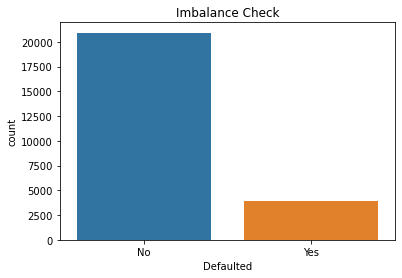

In [5]:
# Checking Imbalance of the data
chart = sns.countplot(x=df['Defaulted'])

chart.set_xticklabels(['No','Yes'])
plt.title("Imbalance Check")
plt.show()

In [6]:
df['Defaulted'].value_counts()

0    20927
1     3953
Name: Defaulted, dtype: int64

## Over & Under Sampling Strategy

In [7]:
# Prepare Dataframe
df2 = df[['SSIC', 
          'Product',
          'Weekday',
          'Day',
          'Month',
          'Year',
          'Tenor',
          'Interest Rate',
          'Amount', 
          'Disbursal Amount', 
          'Payment Amount',
          'Insured', 
          'Defaulted'
         ]]

features = ['SSIC', 
          'Product',
          'Weekday',
          'Day',
          'Month',
          'Year',
          'Tenor',
          'Interest Rate',
          'Amount', 
          'Disbursal Amount', 
          'Payment Amount',
          'Insured', 
         ]

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24880 entries, 0 to 24879
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SSIC              24880 non-null  int64  
 1   Product           24880 non-null  int64  
 2   Weekday           24880 non-null  int64  
 3   Day               24880 non-null  int64  
 4   Month             24880 non-null  int64  
 5   Year              24880 non-null  int64  
 6   Tenor             24880 non-null  int64  
 7   Interest Rate     24880 non-null  float64
 8   Amount            24880 non-null  float64
 9   Disbursal Amount  24880 non-null  float64
 10  Payment Amount    24880 non-null  float64
 11  Insured           24880 non-null  int64  
 12  Defaulted         24880 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 2.5 MB


In [8]:
# Split the y from the dataframe
X = df2.drop(columns = 'Defaulted')
y = df2['Defaulted']

In [9]:
# Over Sampling
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
print(f"Over-sampling:  {Counter(y_ros)}")

# Under Sampling
rus = RandomUnderSampler() 
X_rus, y_rus = rus.fit_resample(X, y)
print(f"Under-sampling: {Counter(y_rus)}")


# Over & Under Sampling Mix
over = RandomOverSampler()
under = RandomUnderSampler()

# Apply oversampling to minority class
X_over, y_over = over.fit_resample(X, y)

# Combine undersampling 
X_rms, y_rms = under.fit_resample(X_over, y_over)

print(f"Mixed Sampling: {Counter(y_rms)}")

Over-sampling:  Counter({0: 20927, 1: 20927})
Under-sampling: Counter({0: 3953, 1: 3953})
Mixed Sampling: Counter({0: 20927, 1: 20927})


## Functions for modelling

In [93]:
# Function to run model and evaluations
def build_model(model_label, model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    prob = np.round(model.predict_proba(X_test), 3)
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Calculate Specificity
    spec = tn / (tn + fp)

    # Calculate Precision
    precision = tp / (tp+fp)

    # Calculate Recall
    recall = tp / (tp+fn)

    # Print results
    print(f'{model_label} Model')
    print("========================")
    print(f'Training Score: {np.round(model.score(X_train, y_train),3)}')
    print(f'Test Score:     {np.round(model.score(X_test, y_test),3)}')
    print("========================")
    print(f'Specificity:     {np.round(spec,3)}')
    print(f'Precision:       {np.round(precision,3)}')
    print(f'Recall:          {np.round(recall,3)}')
    print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
    print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
    print("========================")
    print(f'True Negatives:  {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives:  {tp}')
    
    # Confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    plt.title("Test Results")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve
    base_probs = [0 for _ in range(len(y_test))]
    model_probs = prob[:,1]
    
    # Calculate scores
    base_auc = roc_auc_score(y_test, base_probs)
    auc = roc_auc_score(y_test, model_probs)
    
    # Summarize scores
    print('Baseline: ROC AUC=%.3f' % (base_auc))
    print(f'{model_label}: ROC AUC=%.3f' % (auc))

    # Calculate roc curves
    base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

    # Plot roc curve for the model
    plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
    plt.plot(model_fpr, model_tpr, marker='.', label=model_label)

    # Title
    plt.title(f'{model_label} Results')

    # Axis labels
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.legend()
    plt.show()
    
    return model

## Train, Test, Split

In [12]:
# Variables for test/train/random
test = 0.10
train = 0.90
random = 42

In [87]:
# Normal dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test,
                                                    train_size=train,
                                                    random_state = random)

In [14]:
# Oversampling
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros, y_ros, 
                                                    test_size=test,
                                                    train_size=train,
                                                    random_state = random)

In [15]:
# Undersampling
X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(X_rus, y_rus, 
                                                    test_size=test,
                                                    train_size=train,
                                                    random_state = random)

In [16]:
# Mix of Over & Under sampling
X_rms_train, X_rms_test, y_rms_train, y_rms_test = train_test_split(X_rms, y_rms, 
                                                    test_size=test,
                                                    train_size=train,
                                                    random_state = random)

## Logistic Regression

Logistic Regression Model
Training Score: 0.363
Test Score:     0.367
Specificity:     0.255
Precision:       0.2
Recall:          0.925
Accuracy Score:  0.367
F1:              0.328
True Negatives:  529
False Positives: 1543
False Negatives: 31
True Positives:  385


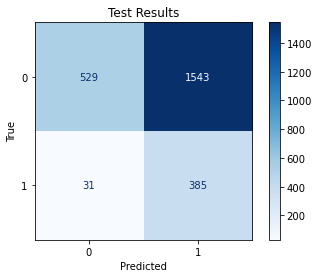

Baseline: ROC AUC=0.500
Logistic Regression: ROC AUC=0.621


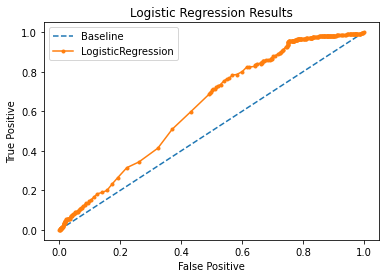

In [17]:
lr = LogisticRegression(class_weight="balanced")
build_model("Logistic Regression", lr, X_train, y_train, X_test, y_test)

Logistic Regression: Over-Sampling Model
Training Score: 0.595
Test Score:     0.598
Specificity:     0.28
Precision:       0.556
Recall:          0.923
Accuracy Score:  0.598
F1:              0.694
True Negatives:  592
False Positives: 1525
False Negatives: 159
True Positives:  1910


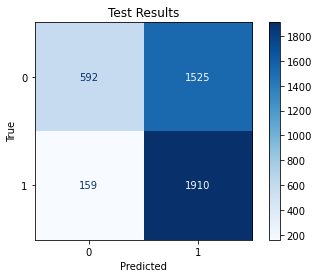

Baseline: ROC AUC=0.500
Logistic Regression: Over-Sampling: ROC AUC=0.640


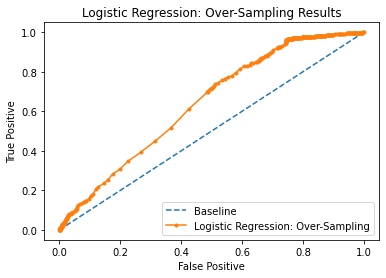

LogisticRegression(class_weight='balanced')

In [99]:
lr = LogisticRegression(class_weight="balanced")
build_model("Logistic Regression: Over-Sampling", lr, X_ros_train, y_ros_train, X_ros_test, y_ros_test)

Logistic Regression: Under-Sampling Model
Training Score: 0.597
Test Score:     0.585
Specificity:     0.286
Precision:       0.545
Recall:          0.901
Accuracy Score:  0.585
F1:              0.679
True Negatives:  116
False Positives: 290
False Negatives: 38
True Positives:  347


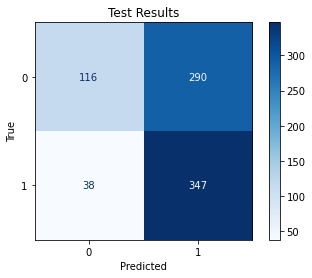

Baseline: ROC AUC=0.500
Logistic Regression: Under-Sampling: ROC AUC=0.620


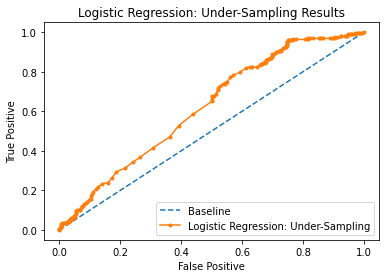

In [22]:
lr = LogisticRegression(class_weight="balanced")
build_model("Logistic Regression: Under-Sampling", lr, X_rus_train, y_rus_train, X_rus_test, y_rus_test)

Logistic Regression: Mixed-Sampling Model
Training Score: 0.594
Test Score:     0.599
Specificity:     0.269
Precision:       0.561
Recall:          0.926
Accuracy Score:  0.599
F1:              0.698
True Negatives:  561
False Positives: 1525
False Negatives: 155
True Positives:  1945


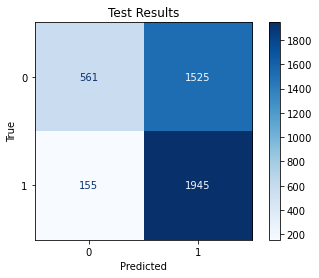

Baseline: ROC AUC=0.500
Logistic Regression: Mixed-Sampling: ROC AUC=0.625


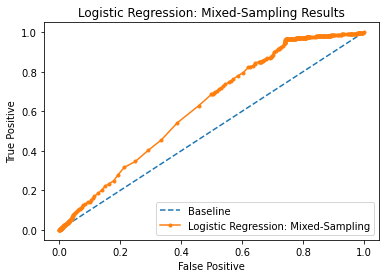

In [23]:
lr = LogisticRegression(class_weight="balanced")
build_model("Logistic Regression: Mixed-Sampling", lr, X_rms_train, y_rms_train, X_rms_test, y_rms_test)

## Decision Tree

In [27]:
# Function to visualize the DecistionTree
def build_tree(model_label, model, X_train, y_train, X_test, y_test):
    
    # compute ccp_alpha values
    path = model.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    dts = []
    for ccp_alpha in ccp_alphas:
        dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        dt.fit(X_train, y_train)
        dts.append(dt)
    

    dts = dts[:-1]
    ccp_alphas = ccp_alphas[:-1]
    
    node_counts = [dt.tree_.node_count for dt in dts]
    depth = [dt.tree_.max_depth for dt in dts]
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("number of nodes")
    ax[0].set_title("Number of nodes vs alpha")
    ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("depth of tree")
    ax[1].set_title("Depth vs alpha")
    fig.tight_layout()

    train_scores = [roc_auc_score(y_train, dt.predict(X_train)) for dt in dts]
    test_scores = [roc_auc_score(y_test, dt.predict(X_test)) for dt in dts]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("AUC-ROC score vs alpha")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test")
    ax.legend()
    plt.show()
    
    # Plot our tree.
    plot_tree(model);
    
    return model
    

DecisionTree Model
Training Score: 0.786
Test Score:     0.751
Specificity:     0.752
Precision:       0.376
Recall:          0.745
Accuracy Score:  0.751
F1:              0.5
True Negatives:  1558
False Positives: 514
False Negatives: 106
True Positives:  310


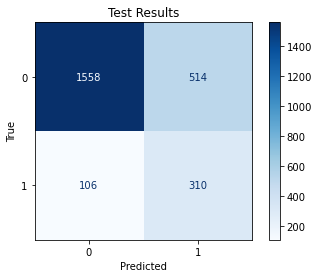

Baseline: ROC AUC=0.500
DecisionTree: ROC AUC=0.819


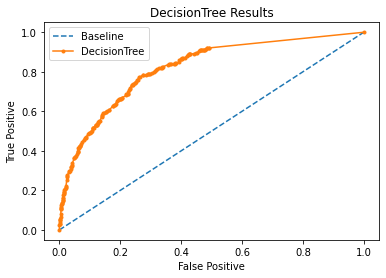

In [24]:
dt1 = DecisionTreeClassifier(class_weight = "balanced",
                            max_depth = 40,
                            min_samples_split = 30,
                            min_samples_leaf = 20,
                            random_state = 10)

build_model("DecisionTree", dt1, X_train, y_train, X_test, y_test)

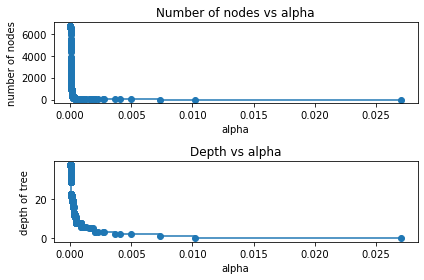

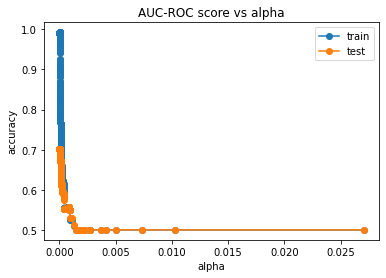

DecisionTreeClassifier(class_weight='balanced', max_depth=40,
                       min_samples_leaf=20, min_samples_split=30,
                       random_state=10)

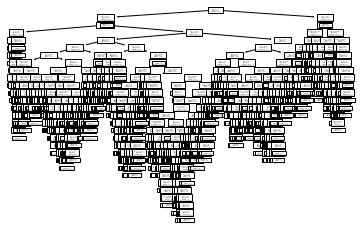

In [28]:
build_tree("DecisionTree", dt1, X_train, y_train, X_test, y_test)

In [25]:
dt1_r = export_text(dt1, feature_names = features)
print(dt1_r)

|--- Tenor <= 5.50
|   |--- Year <= 2021.50
|   |   |--- Interest Rate <= 0.53
|   |   |   |--- Interest Rate <= 0.47
|   |   |   |   |--- Insured <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Insured >  0.50
|   |   |   |   |   |--- Year <= 2019.50
|   |   |   |   |   |   |--- Month <= 6.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Month >  6.50
|   |   |   |   |   |   |   |--- Disbursal Amount <= 1845.05
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Disbursal Amount >  1845.05
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Year >  2019.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Interest Rate >  0.47
|   |   |   |   |--- Day <= 22.50
|   |   |   |   |   |--- Payment Amount <= 26650.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Payment Amount >  26650.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Day >  22.50
|   |   |   |   |   |--- 

DecisionTree - Oversampling Model
Training Score: 0.856
Test Score:     0.817
Specificity:     0.785
Precision:       0.794
Recall:          0.85
Accuracy Score:  0.817
F1:              0.821
True Negatives:  1662
False Positives: 455
False Negatives: 310
True Positives:  1759


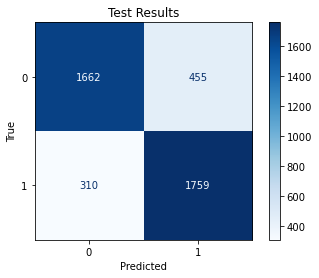

Baseline: ROC AUC=0.500
DecisionTree - Oversampling: ROC AUC=0.907


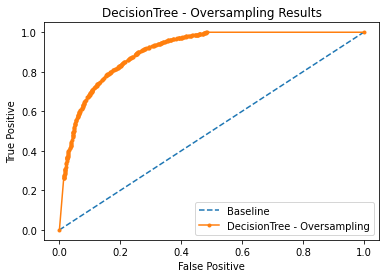

In [90]:
dt2 = DecisionTreeClassifier(class_weight = "balanced",
                            max_depth = 40,
                            min_samples_split = 30,
                            min_samples_leaf = 20,
                            random_state = 10)

build_model("DecisionTree - Oversampling", dt2, X_ros_train, y_ros_train, X_ros_test, y_ros_test)

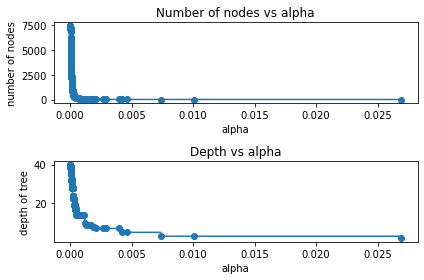

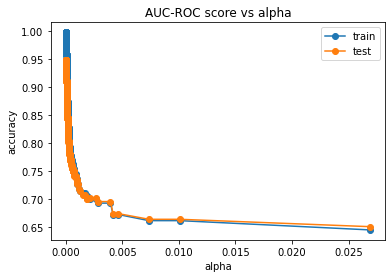

DecisionTreeClassifier(class_weight='balanced', max_depth=40,
                       min_samples_leaf=20, min_samples_split=30,
                       random_state=10)

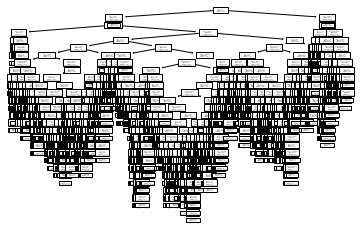

In [91]:
build_tree("DecisionTree - Oversampling", dt2, X_ros_train, y_ros_train, X_ros_test, y_ros_test)

In [92]:
dt2_r = export_text(dt2, feature_names = features)
print(dt2_r)

|--- Tenor <= 5.50
|   |--- Year <= 2021.50
|   |   |--- Interest Rate <= 0.53
|   |   |   |--- Year <= 2019.50
|   |   |   |   |--- Month <= 6.50
|   |   |   |   |   |--- SSIC <= 33503.00
|   |   |   |   |   |   |--- Day <= 29.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Day >  29.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- SSIC >  33503.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Month >  6.50
|   |   |   |   |   |--- Interest Rate <= 0.45
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Interest Rate >  0.45
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Year >  2019.50
|   |   |   |   |--- Insured <= 0.50
|   |   |   |   |   |--- Month <= 3.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Month >  3.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Insured >  0.50
|   |   |   |   |   |--- Interest Rate <= 0.48
|   |   |   |   |   |   |--- Month <= 1.50
|   |  

In [ ]:
dt3 = DecisionTreeClassifier(class_weight = "balanced",
                            max_depth = 40,
                            min_samples_split = 30,
                            min_samples_leaf = 20,
                            random_state = 10)

build_model("DecisionTree - Undersampling", dt3, X_rus_train, y_rus_train, X_test, y_test)

In [ ]:
build_tree("DecisionTree - Undersampling", dt3, X_rus_train, y_rus_train, X_test, y_test)

In [ ]:
dt3_r = export_text(dt3, feature_names = features)
print(dt3_r)

In [ ]:
dt4 = DecisionTreeClassifier(class_weight = "balanced",
                            max_depth = 40,
                            min_samples_split = 30,
                            min_samples_leaf = 20,
                            random_state = 10)

build_model("DecisionTree - Undersampling", dt4, X_rms_train, y_rms_train, X_test, y_test)

In [ ]:
build_tree("DecisionTree - Undersampling", dt4, X_rms_train, y_rms_train, X_test, y_test)

In [ ]:
dt4_r = export_text(dt4, feature_names = features)
print(dt4_r)

### GridSearch DecisionTree

Fitting 5 folds for each of 3432 candidates, totalling 17160 fits
GridSearchCV / DecistionTree Model
Training Score: 0.898
Test Score:     0.848
Specificity:     0.961
Precision:       0.595
Recall:          0.286
Accuracy Score:  0.848
F1:              0.386
True Negatives:  1991
False Positives: 81
False Negatives: 297
True Positives:  119


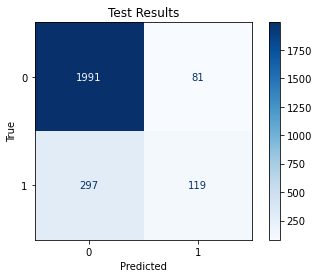

Baseline: ROC AUC=0.500
GridSearchCV / DecistionTree: ROC AUC=0.797


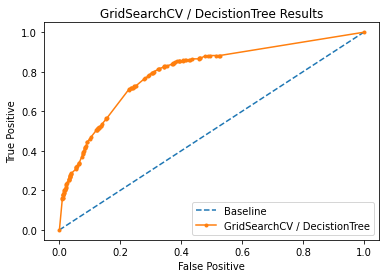

In [33]:
dt_grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                                  'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]},
                    cv = 5,
                    verbose = 1)

build_model("GridSearchCV / DecistionTree", dt_grid, X_train, y_train, X_test, y_test)

print("========================")
print(f'Best Score: {dt_grid.best_score_}')
print(f'Best Parameters: {dt_grid.best_params_}')

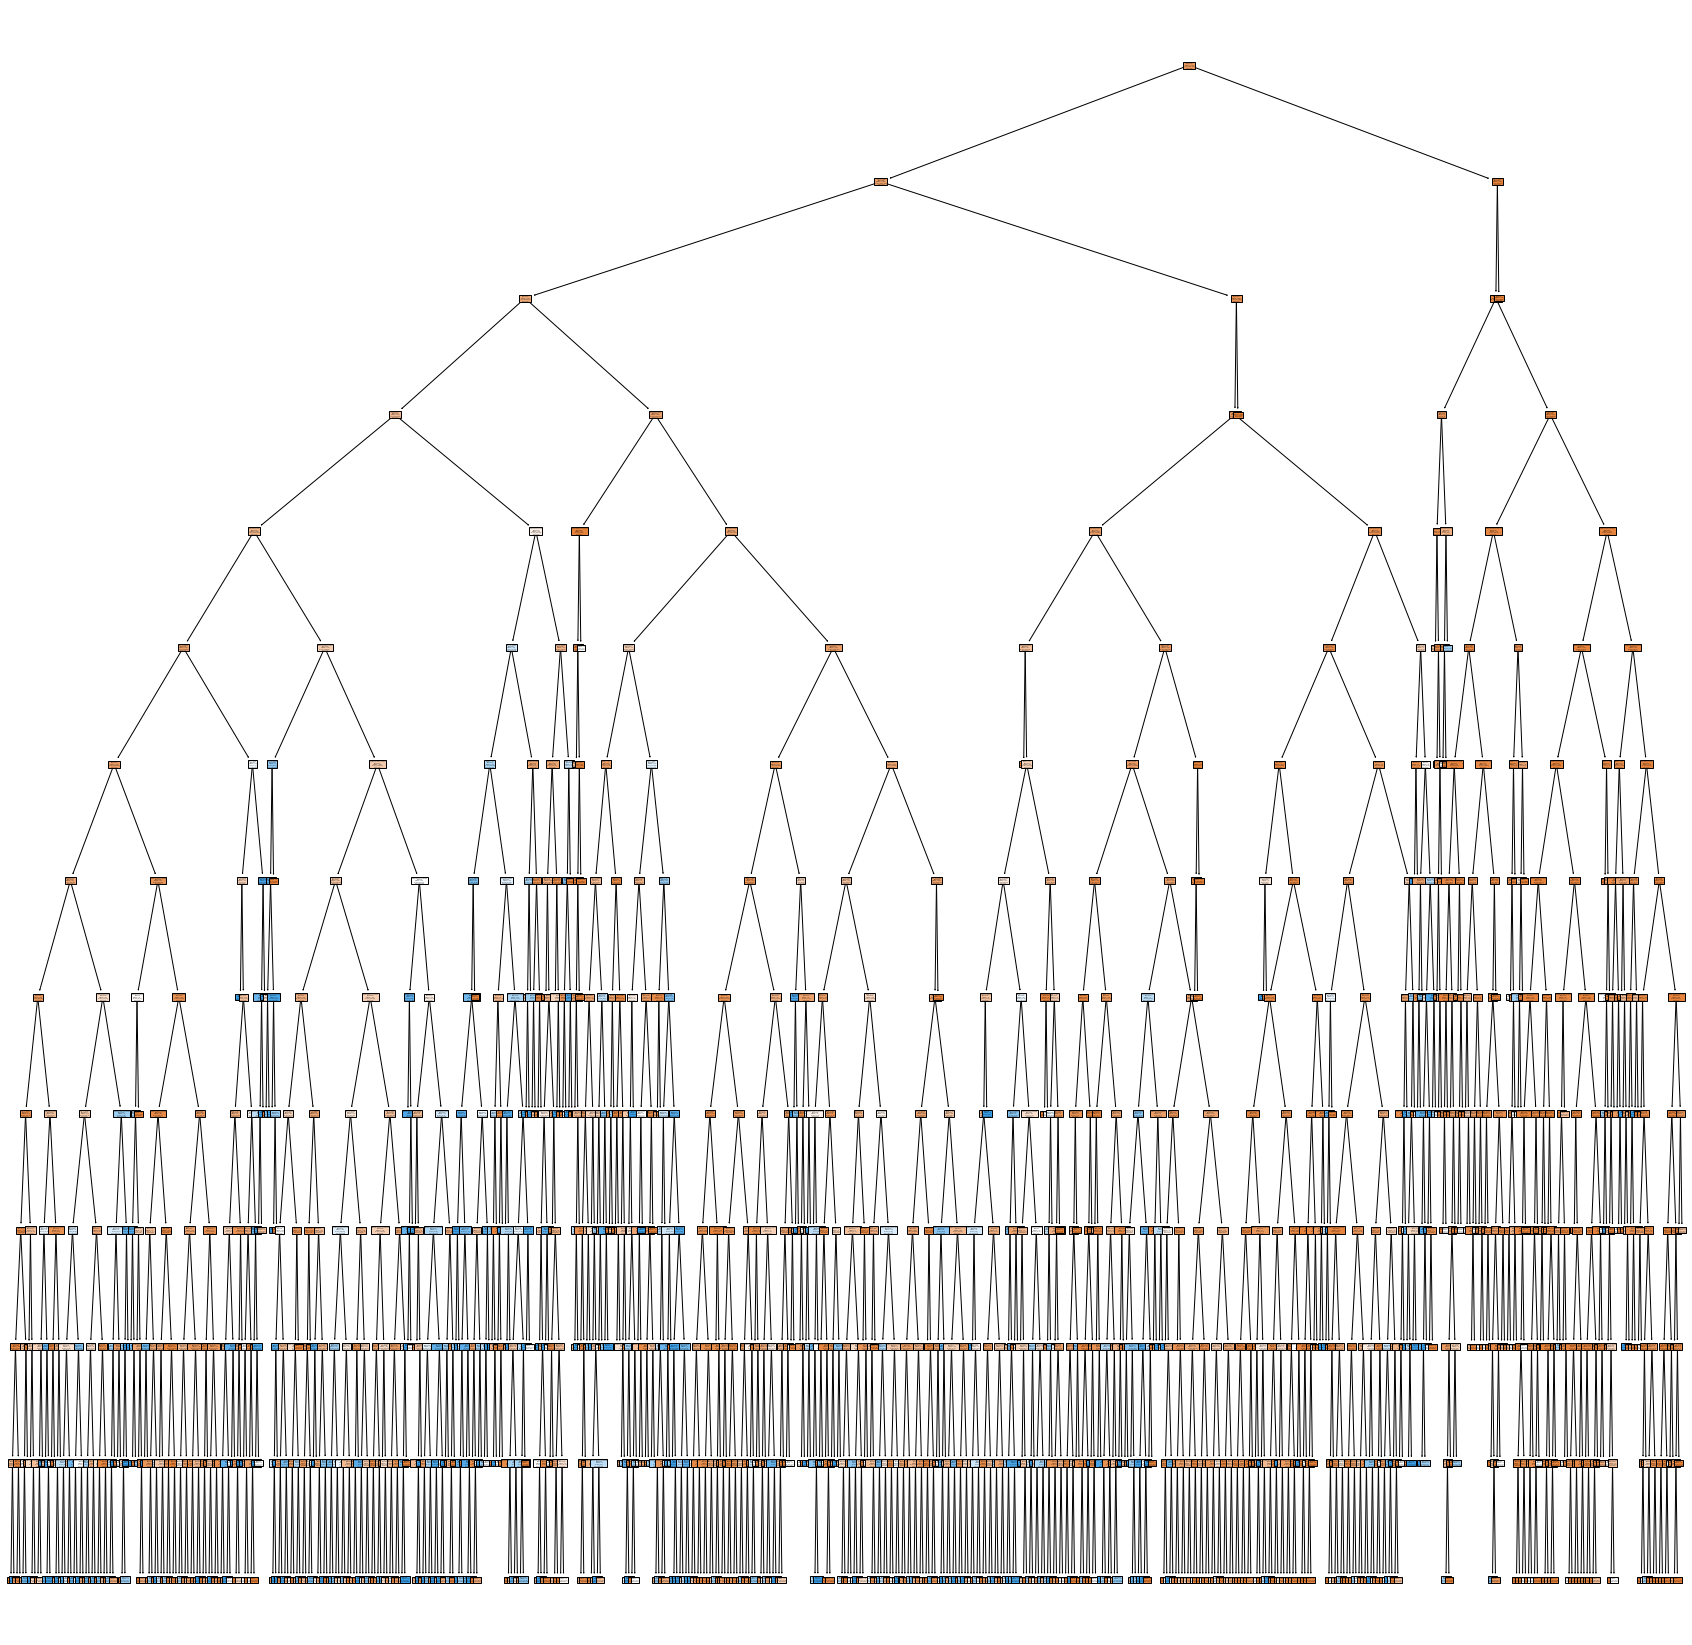

In [44]:
# Plot DecisionTree
plt.figure(figsize = (30, 30))
plot_tree(dt_grid.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Paid', 'Defaulted'],
          filled = True);

In [36]:
grid_r = export_text(dt_grid.best_estimator_, feature_names = features)
print(grid_r)

|--- Tenor <= 5.50
|   |--- Year <= 2020.50
|   |   |--- Tenor <= 4.50
|   |   |   |--- Tenor <= 3.50
|   |   |   |   |--- Interest Rate <= 1.45
|   |   |   |   |   |--- SSIC <= 83856.00
|   |   |   |   |   |   |--- SSIC <= 46379.50
|   |   |   |   |   |   |   |--- Product <= 2.50
|   |   |   |   |   |   |   |   |--- SSIC <= 41005.00
|   |   |   |   |   |   |   |   |   |--- Year <= 2018.50
|   |   |   |   |   |   |   |   |   |   |--- Tenor <= 2.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- Tenor >  2.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- Year >  2018.50
|   |   |   |   |   |   |   |   |   |   |--- Amount <= 8250.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- Amount >  8250.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |

# AdaBoostClassifier

AdaBoostClassifier Model
Training Score: 0.887
Test Score:     0.86
Specificity:     0.979
Precision:       0.672
Recall:          0.232
Accuracy Score:  0.86
F1:              0.345
True Negatives:  5120
False Positives: 112
False Negatives: 759
True Positives:  229


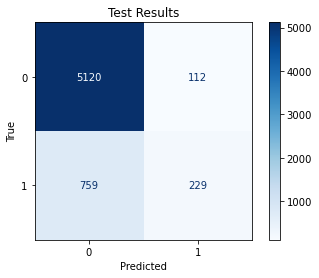

Baseline: ROC AUC=0.500
AdaBoostClassifier: ROC AUC=0.852


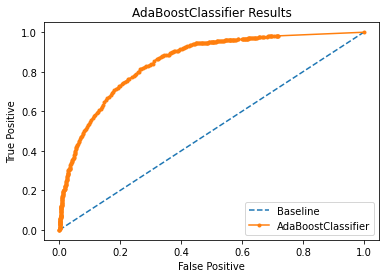

Best Score: 0.8662915326902464
Best Parameters: {'base_estimator__max_depth': 10, 'learning_rate': 0.07, 'n_estimators': 110}


In [98]:
# Stratify dataset
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X, y, random_state=42, stratify=y)

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm="SAMME", n_estimators=200)
ada_params = {
    'n_estimators': [50,100, 110],
    'base_estimator__max_depth': [8,9,10],
    'learning_rate': [0.01, 0.05, 0.07 ]
}
gs_ada = GridSearchCV(ada, n_jobs=-1, param_grid=ada_params, cv=5)
build_model("AdaBoostClassifier", gs_ada, X_a_train, y_a_train, X_a_test, y_a_test)

print("========================")
print(f'Best Score: {gs_ada.best_score_}')
print(f'Best Parameters: {gs_ada.best_params_}')

# GradientBoostingClassifier

GradientBoosting Model
Training Score: 0.878
Test Score:     0.855
Specificity:     0.986
Precision:       0.743
Recall:          0.202
Accuracy Score:  0.855
F1:              0.318
True Negatives:  2043
False Positives: 29
False Negatives: 332
True Positives:  84


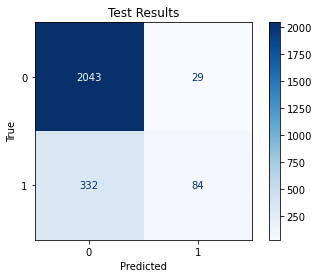

Baseline: ROC AUC=0.500
GradientBoosting: ROC AUC=0.830


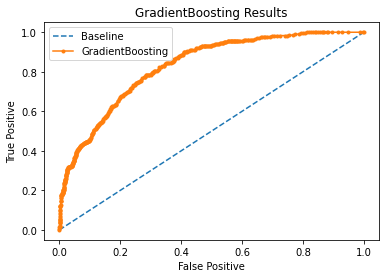

GradientBoosting best score: 0.8643712040014292
GradientBostting best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [46]:
gboost1 = GradientBoostingClassifier()
gboost1_params = {
    'max_depth': [2,3,4],
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200],
    'learning_rate': [.08, .1, .12]
}
gb_gs1 = GridSearchCV(gboost, n_jobs=-1, param_grid=gboost1_params, cv=3)

build_model("GradientBoosting", gb_gs1, X_train, y_train, X_test, y_test)

print("========================")
print(f'GradientBoosting best score: {gb_gs1.best_score_}')
print(f'GradientBostting best parameters: {gb_gs1.best_params_}')

GradientBoosting - Oversampling Model
Training Score: 0.993
Test Score:     0.975
Specificity:     0.971
Precision:       0.872
Recall:          0.995
Accuracy Score:  0.975
F1:              0.929
True Negatives:  2011
False Positives: 61
False Negatives: 2
True Positives:  414


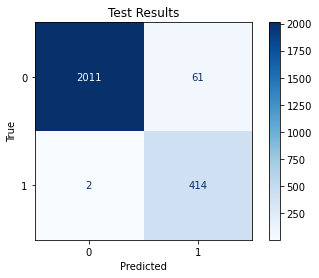

Baseline: ROC AUC=0.500
GradientBoosting - Oversampling: ROC AUC=0.996


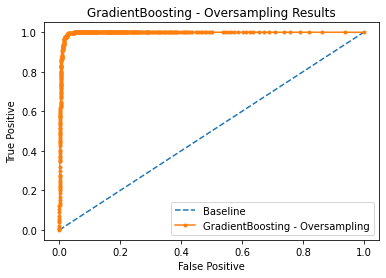

GradientBoosting best score: 0.9318519698417754
GradientBostting best parameters: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 225}


In [63]:
gboost2 = GradientBoostingClassifier()
gboost2_params = {
    'max_depth': [4,6,8],
    'n_estimators': [175, 200, 225],
    'learning_rate': [.08, .1, .12, 0.2]
}
gb_gs2 = GridSearchCV(gboost2, n_jobs=-1, param_grid=gboost2_params, cv=3)

build_model("GradientBoosting - Oversampling", gb_gs2, X_ros_train, y_ros_train, X_test, y_test)

print("========================")
print(f'GradientBoosting best score: {gb_gs2.best_score_}')
print(f'GradientBostting best parameters: {gb_gs2.best_params_}')

GradientBoosting - Undersampling Model
Training Score: 0.747
Test Score:     0.714
Specificity:     0.599
Precision:       0.674
Recall:          0.83
Accuracy Score:  0.714
F1:              0.744
True Negatives:  592
False Positives: 397
False Negatives: 168
True Positives:  820


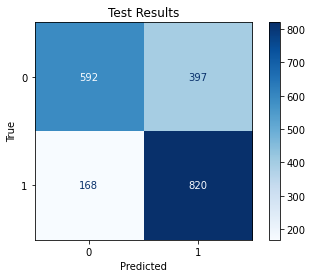

Baseline: ROC AUC=0.500
GradientBoosting - Undersampling: ROC AUC=0.799


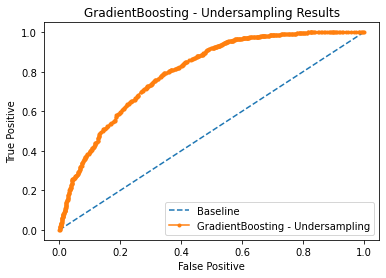

GradientBoosting best score: 0.7252485909142726
GradientBostting best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 175}


In [97]:
gboost3 = GradientBoostingClassifier()
gboost3_params = {
    'max_depth': [1,2,3],
    'n_estimators': [100, 150, 175],
    'learning_rate': [0.03, 0.04, 0.05]
}
gb_gs3 = GridSearchCV(gboost3, n_jobs=-1, param_grid=gboost3_params, cv=3)

X_arus_train, X_arus_test, y_arus_train, y_arus_test = train_test_split(X_rus, y_rus, random_state=42, stratify=y_rus)

build_model("GradientBoosting - Undersampling", gb_gs3, X_arus_train, y_arus_train, X_arus_test, y_arus_test)

print("========================")
print(f'GradientBoosting best score: {gb_gs3.best_score_}')
print(f'GradientBostting best parameters: {gb_gs3.best_params_}')

GradientBoosting - Mixed Sampling Model
Training Score: 0.882
Test Score:     0.842
Specificity:     0.833
Precision:       0.517
Recall:          0.892
Accuracy Score:  0.842
F1:              0.654
True Negatives:  1725
False Positives: 347
False Negatives: 45
True Positives:  371


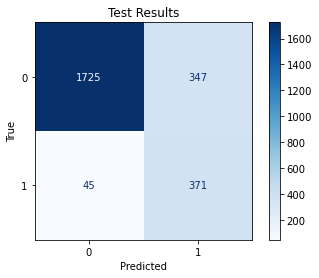

Baseline: ROC AUC=0.500
GradientBoosting - Mixed Sampling: ROC AUC=0.942


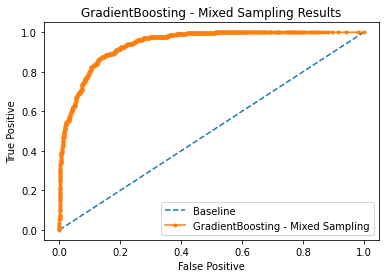

GradientBoosting best score: 0.8418551555697144
GradientBostting best parameters: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 250}


In [62]:
gboost4 = GradientBoostingClassifier()
gboost4_params = {
    'max_depth': [2,3,4],
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 250],
    'learning_rate': [.08, .1, .12, 0.2, 0.3]
}
gb_gs4 = GridSearchCV(gboost4, n_jobs=-1, param_grid=gboost4_params, cv=3)

build_model("GradientBoosting - Mixed Sampling", gb_gs4, X_rms_train, y_rms_train, X_test, y_test)

print("========================")
print(f'GradientBoosting best score: {gb_gs4.best_score_}')
print(f'GradientBostting best parameters: {gb_gs4.best_params_}')

# VotingClassifier

VotingClassifier
Training Score: 0.87
Test Score:     0.856
Specificity:     0.986
Precision:       0.695
Recall:          0.168
Accuracy Score:  0.856
F1:              0.271
True Negatives:  5159
False Positives: 73
False Negatives: 822
True Positives:  166


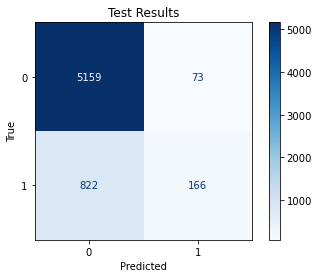

In [74]:
vote = VotingClassifier([
    ('tree', DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier())
])

vote_params = {
    'ada__n_estimators': [25,50,75,100,125,150,175,200],
    'gb__n_estimators': [100,125,150,175,200],
    'tree__max_depth': [None, 1,2,3,4,5,6,7,8,9,10]
}

gs_vc = GridSearchCV(vote, n_jobs = -1, param_grid=vote_params, cv=3)
    
gs_vc.fit(X_train, y_train)
    
preds = gs_vc.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
spec = tn / (tn + fp)
precision = tp / (tp+fp)
recall = tp / (tp+fn)

print("VotingClassifier")
print("========================")
print(f'Training Score: {np.round(gs_vc.score(X_train, y_train),3)}')
print(f'Test Score:     {np.round(gs_vc.score(X_test, y_test),3)}')
print("========================")
print(f'Specificity:     {np.round(spec,3)}')
print(f'Precision:       {np.round(precision,3)}')
print(f'Recall:          {np.round(recall,3)}')
print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
print("========================")
print(f'True Negatives:  {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')
   
# Confusion matrix
plot_confusion_matrix(gs_vc, X_test, y_test, cmap='Blues', values_format='d');
plt.title("Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()